In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#Upload CSV file
scaled_data = pd.read_csv("Data/scaled_data.csv")

In [2]:
# List of variables according to group
Gender_Features = scaled_data.columns[1:2].tolist()
Baseline_Features = scaled_data.columns[2:23].tolist()
Time_Freq_Features = scaled_data.columns[23:34].tolist()
Vocal_Fold_Features = scaled_data.columns[34:56].tolist()
MFCC_Features = scaled_data.columns[56:140].tolist()
WT_FT_Features = scaled_data.columns[140:322].tolist()
TQWT_Features = scaled_data.columns[322:754].tolist()
Class = scaled_data.columns[754]

In [3]:
X = scaled_data.iloc[:, 1:754]  # Features
y = scaled_data.iloc[:, 754]    # Class
grup = scaled_data["id"]        # Stablish as indivisible group: subject id for CV

## PCA

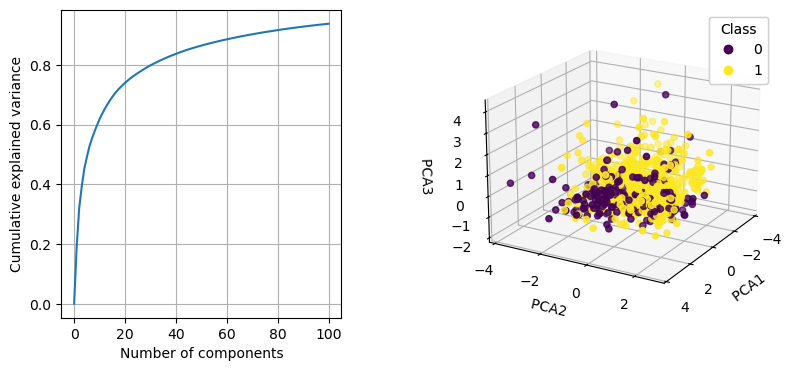

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

#PCA Analysis
pca = PCA(n_components = 100)
X_pca = pca.fit_transform(X) 

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
explained_variance_ratio0 = np.append(0, explained_variance_ratio)  

# Figure space
fig = plt.figure(figsize=(14, 4))
gs = GridSpec(1, 2, width_ratios=[1, 2]) 

# Figure cumulative variance
ax1 = fig.add_subplot(gs[0])
ax1.plot(explained_variance_ratio0)
ax1.grid()
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Cumulative explained variance')

# Plot according PCA1, PCA2 and PCA3
ax2 = fig.add_subplot(gs[1], projection='3d')
scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1],X_pca[:, 2], c=y)
ax2.set_xlabel('PCA1 ')
ax2.set_ylabel('PCA2 ')
ax2.set_zlabel('PCA3 ')
ax2.view_init(elev=20, azim=30) 

legend = ax2.legend(*scatter.legend_elements(), title="Class", loc='best')
ax2.add_artist(legend)


plt.subplots_adjust(left=0.1, right=0.7, wspace=0) 
plt.show()

In [5]:
# PCA separated from each group of features

feature_groups = [Baseline_Features, Time_Freq_Features, Vocal_Fold_Features,
                   MFCC_Features, WT_FT_Features, TQWT_Features ]
feature_names = ["Baseline_Features", "Time_Freq_Features",  "Vocal_Fold_Features",
                 "MFCC_Features","WT_FT_Features", "TQWT_Features" ]

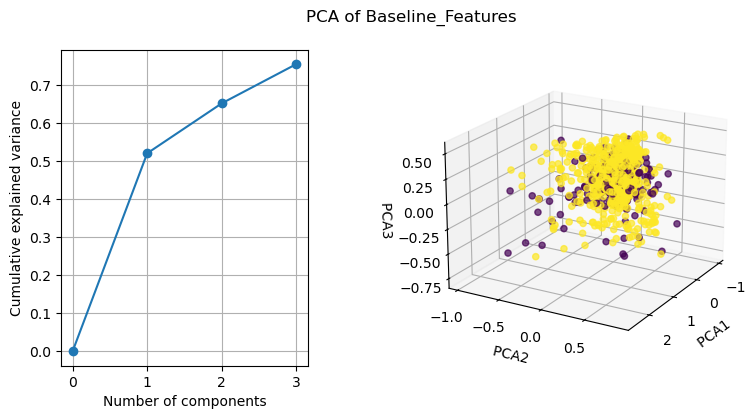

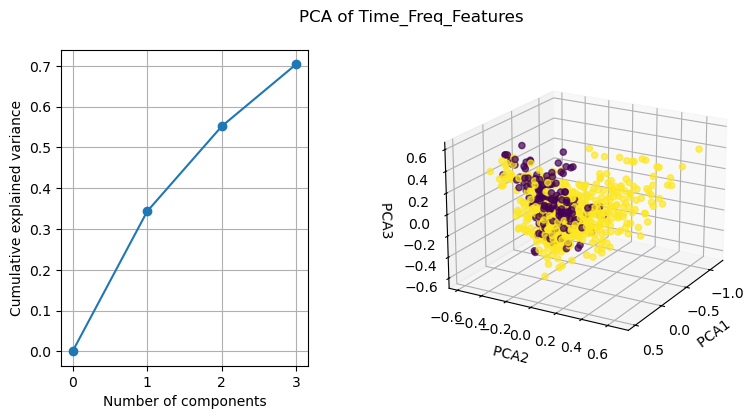

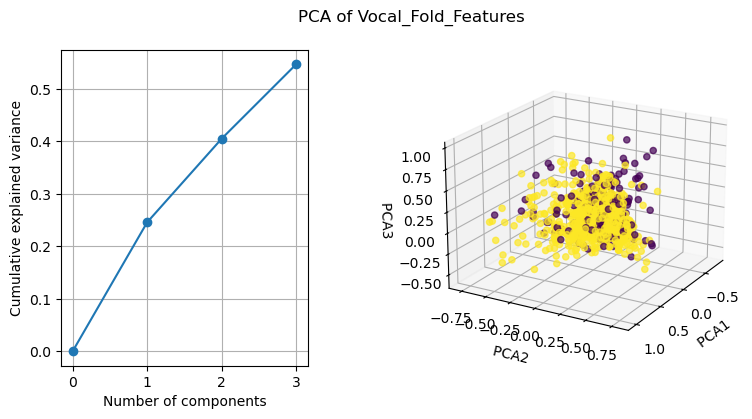

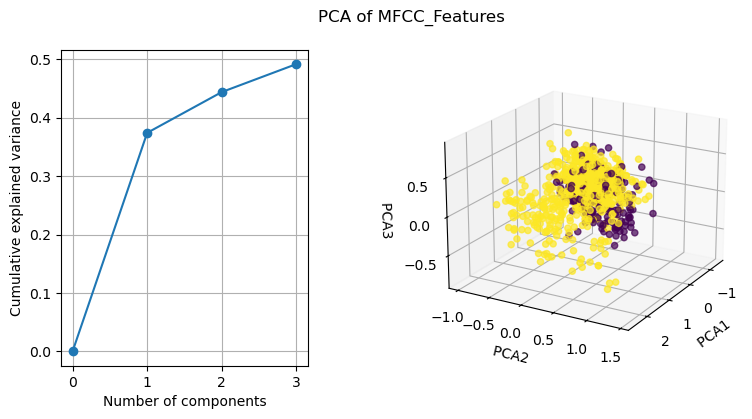

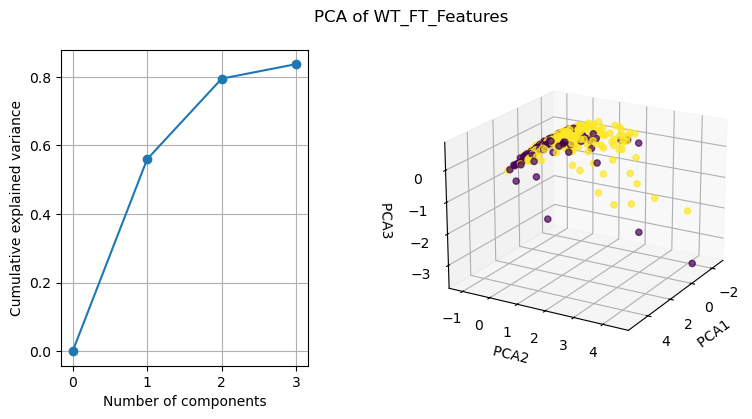

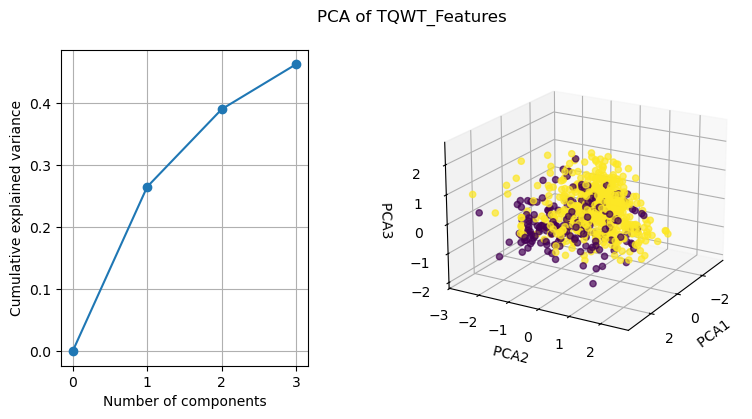

In [6]:
# PCA Analysis, only 3 components

for i,features in enumerate(feature_groups):
    selected_features = scaled_data[features]
    
    pca = PCA(n_components = 3)
    X_pca = pca.fit_transform(selected_features) 
    
    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    explained_variance_ratio0 = np.append(0, explained_variance_ratio) 
    
    # Figure space
    fig = plt.figure(figsize=(10,4))
    gs = fig.add_gridspec(1, 2, width_ratios=[0.8,1.8]) 

    # Figure cumulative variance
    ax1 = fig.add_subplot(gs[0,0])
    ax1.plot(explained_variance_ratio0, marker='o')
    ax1.grid()
    ax1.set_xlabel('Number of components')
    ax1.set_ylabel('Cumulative explained variance')
    ax1.set_xticks(range(len(explained_variance_ratio0))) 

    # Plot according PCA1, PCA2 and PCA3
    ax2 = fig.add_subplot(gs[0,1], projection='3d')
    scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, alpha=0.7)
    ax2.set_xlabel('PCA1 ')
    ax2.set_ylabel('PCA2 ')
    ax2.set_zlabel('PCA3 ')
    ax2.view_init(elev=20, azim=30) 

    plt.suptitle(f"PCA of {feature_names[i]}", fontsize=12, y=1, x=0.45)  # Ajustar y per centrar el títol
    plt.subplots_adjust(left=0.1, right=0.9, wspace=0, top=0.9)
    
    plt.show()


### MFA

In [7]:
import prince

# Data reorganization
groups = {  
    "Gender_Features" : scaled_data.columns[1:2].tolist(),
    "Baseline_Features": scaled_data.columns[2:23].tolist(),
    "Time_Freq_Features": scaled_data.columns[23:34].tolist(),
    "Vocal_Fold_Features": scaled_data.columns[34:56].tolist(),
    "MFCC_Features":  scaled_data.columns[56:140].tolist(),
    "WT_FT_Features": scaled_data.columns[140:322].tolist(),
    "TQWT_Features": scaled_data.columns[322:754].tolist()
}

# Create MultiIndex for groups of variables
arrays = []
for group, features in groups.items():
    arrays.append([(group, feature) for feature in features])

# Array of tupples
flattened_arrays = [item for sublist in arrays for item in sublist]

# Create new MultiIndex
multi_index = pd.MultiIndex.from_tuples(flattened_arrays, names=['Group', 'Feature'])

new_columns = [feature for features in groups.values() for feature in features]
scaled_data_multi = scaled_data[new_columns].copy()
scaled_data_multi.columns = multi_index

# Specify groups (subject id)
gr = scaled_data_multi.columns.levels[0].tolist()

In [8]:
# MFA analysis
num_components = 10

mfa = prince.MFA(
    n_components=num_components,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=123 )

mfa = mfa.fit(scaled_data_multi, groups=gr)
mfa_projected = mfa.transform(scaled_data_multi)


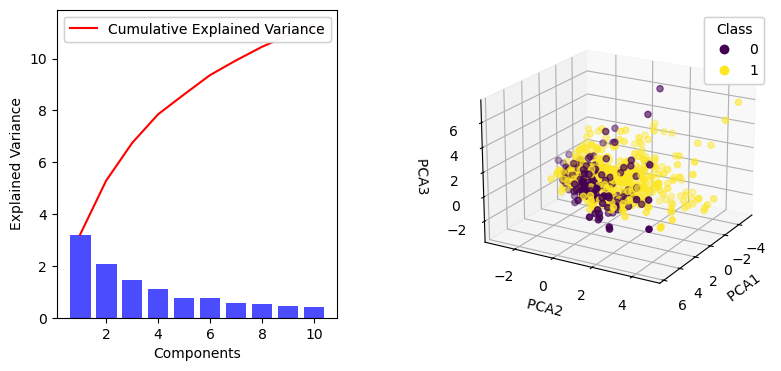

In [9]:
# Figure space
fig = plt.figure(figsize=(14, 4))
gs = GridSpec(1, 2, width_ratios=[1, 2]) 

# Figure eigenvalues
ax1 = fig.add_subplot(gs[0])
ax1.bar(range(1, num_components + 1), mfa.eigenvalues_, color='b', alpha=0.7)
ax1.plot(range(1, num_components +1), np.cumsum(mfa.eigenvalues_),
        c='red',label='Cumulative Explained Variance')
ax1.set_xlabel('Components')
ax1.set_ylabel('Explained Variance')
ax1.add_artist(plt.legend(loc='upper left'))


# Plot according PCA1, PCA2 and PCA3
ax2 = fig.add_subplot(gs[1], projection='3d')
scatter = ax2.scatter(mfa_projected.iloc[:, 0], mfa_projected.iloc[:, 1],mfa_projected.iloc[:, 2], c=y)
ax2.set_xlabel('PCA1 ')
ax2.set_ylabel('PCA2 ')
ax2.set_zlabel('PCA3 ')
ax2.view_init(elev=20, azim=30) 

legend = ax2.legend(*scatter.legend_elements(), title="Class", loc='best')
ax2.add_artist(legend)


plt.subplots_adjust(left=0.1, right=0.7, wspace=0) 
plt.show()


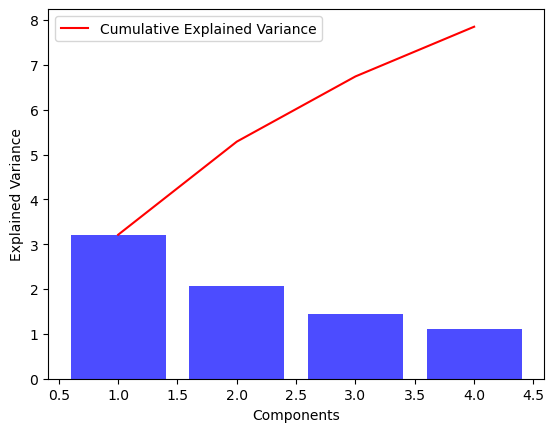

In [10]:
# Figure eigenvalues of first 4 components
num_components = 4

mfa = prince.MFA(
    n_components=num_components,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=123 )

mfa = mfa.fit(scaled_data_multi, groups=gr)
mfa_projected = mfa.transform(scaled_data_multi)

plt.bar(range(1, num_components + 1), mfa.eigenvalues_, color='b', alpha=0.7)
plt.plot(range(1, num_components +1), np.cumsum(mfa.eigenvalues_),
        c='red',label='Cumulative Explained Variance')
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.legend(loc='upper left')
plt.show()

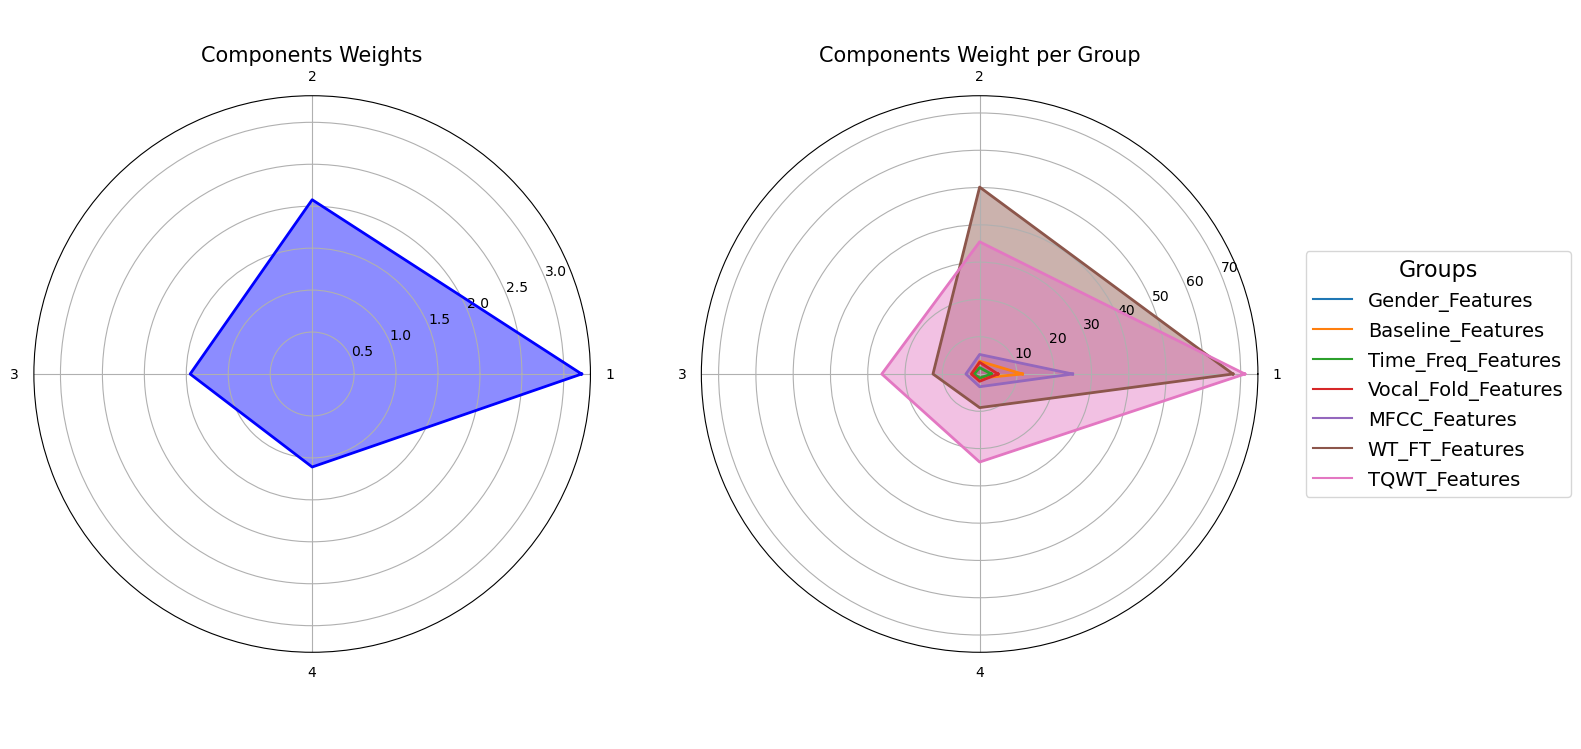

In [11]:
# MFA analysis Component number = 4

# Figure space
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(1, 3, width_ratios=[2, 2,0.5]) 

# Plot general components
ax1 = plt.subplot(gs[0], polar=True)
eigenvalues = mfa.eigenvalues_ 
angles = np.linspace(0, 2 * np.pi, len(eigenvalues), endpoint=False).tolist()
eigenvalues = np.concatenate((eigenvalues, [eigenvalues[0]]))  
angles += angles[:1]  

ax1.fill(angles, eigenvalues, color='b', alpha=0.45, label='Components Weights')
ax1.plot(angles, eigenvalues, color='b', linewidth=2)
ax1.set_title("Components Weights", size=15)
ax1.set_xticks(angles[:-1])  
ax1.set_xticklabels(range(1, len(eigenvalues))) 

# Plot per group
ax2 = plt.subplot(gs[1], polar=True)

colors = plt.get_cmap('tab10').colors  
legend_elements = [] # legend apart

for idx, group in enumerate(groups.keys()):  # Plot eigenvalues per group
    eigenvalues_group = mfa[group].eigenvalues_  
    angles_group = np.linspace(0, 2 * np.pi, len(eigenvalues_group), endpoint=False).tolist()
    eigenvalues_group = np.concatenate((eigenvalues_group, [eigenvalues_group[0]])) 
    angles_group += angles_group[:1]  

    ax2.fill(angles_group, eigenvalues_group, color=colors[idx % len(colors)], alpha=0.45, label=f"{group}")  
    ax2.plot(angles_group, eigenvalues_group, color=colors[idx % len(colors)], linewidth=2)  
    legend_elements.append((colors[idx % len(colors)], group))

ax2.set_title("Components Weight per Group", size=15)
ax2.set_xticks(angles_group[:-1]) 
ax2.set_xticklabels(range(1, len(eigenvalues_group)))  

# Legend
ax_legend = plt.subplot(gs[2])  
ax_legend.axis('off') 

for color, label in legend_elements:
    ax_legend.plot([], [], color=color, label=label) 
ax_legend.legend(title="Groups", loc='center', title_fontsize=16, fontsize=14)

# Plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### t-SNE

In [12]:
import numpy as np
from sklearn.manifold import TSNE

In [13]:
tsne = TSNE(n_components=3, perplexity=15, random_state=123)
tsne_results = tsne.fit_transform(X)

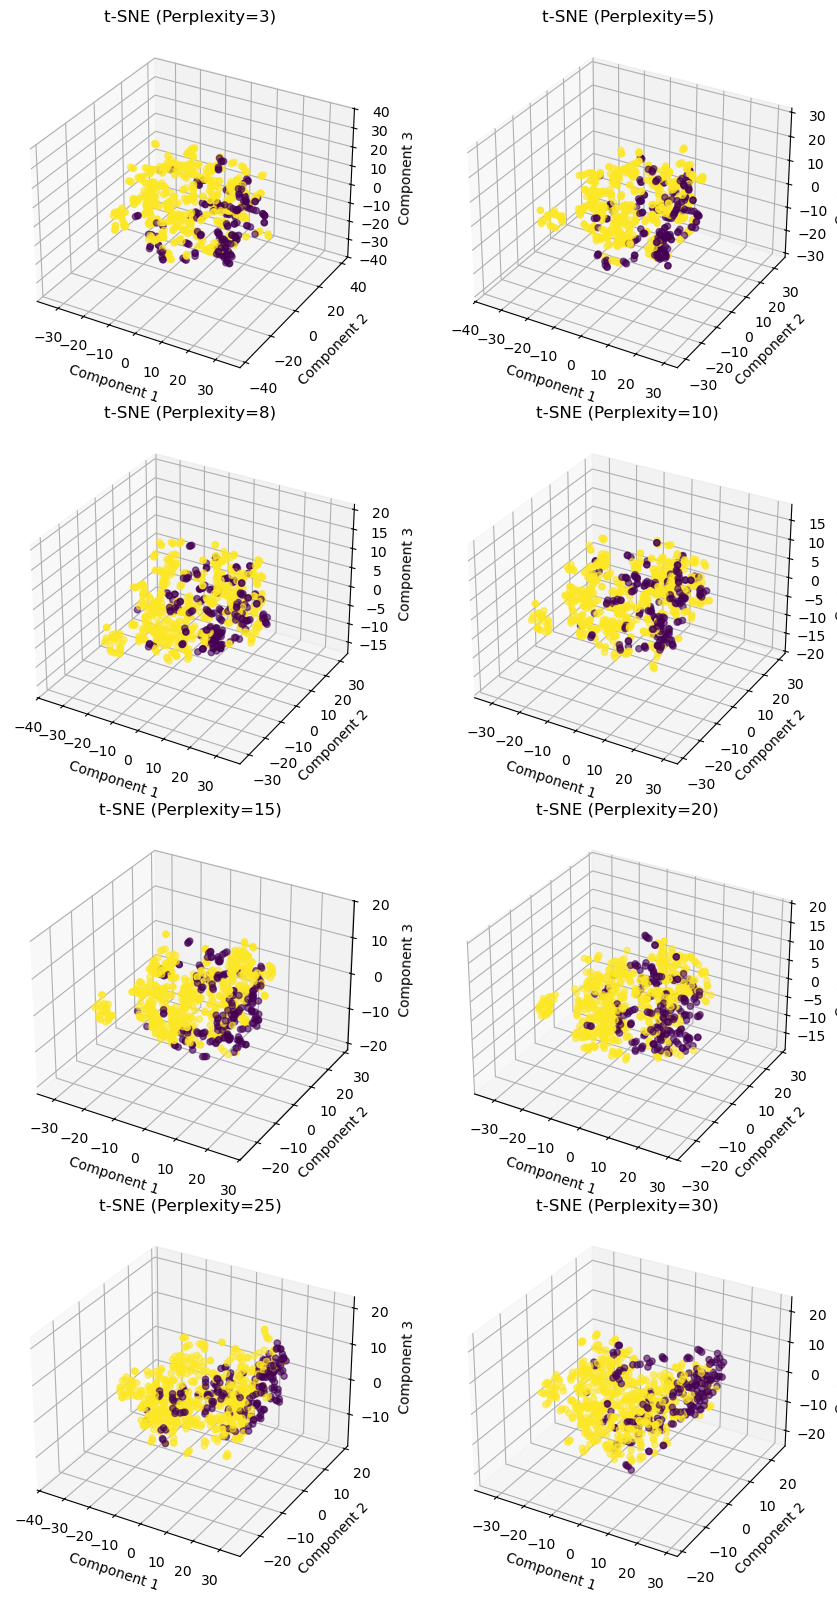

In [14]:
n_perplexity = [3,5,8,10,15,20,25,30]

fig, axes = plt.subplots(4, 2, figsize=(10, 16), subplot_kw={'projection': '3d'})
axes = axes.flatten()

for i, n in enumerate(n_perplexity):
    tsne = TSNE(n_components=3, perplexity=n, random_state=123)
    tsne_results = tsne.fit_transform(X)
    
    # Visualize the results in 3D
    ax = axes[i]
    scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], c=y, alpha=0.6)

    # Set titles and labels
    ax.set_title(f"t-SNE (Perplexity={n})")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    ax.margins(0.2) 
    
plt.subplots_adjust(wspace=0.05) 
plt.tight_layout()
plt.show()
